# Installs, Imports, Drive Connection, WandB Connection

##### Installs

In [ ]:
# !pip install transformers
!pip install git+https://github.com/huggingface/transformers.git
!pip install datasets==1.9.0
!pip install -U PyYAML
!pip install "ray[default]"
!pip install wandb
!pip install tensorboardX

##### Imports

In [2]:
import sys
import os
import numpy as np
# from transformers import pipeline
from datasets import concatenate_datasets, load_dataset
import torch
from pathlib import Path
import pickle
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments
from scipy.special import softmax
from sklearn.metrics import f1_score, precision_recall_curve, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import math
from transformers import AutoModelForSequenceClassification

In [ ]:
import os
import pickle
import numpy as np

import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import PopulationBasedTraining, ASHAScheduler
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from ray.tune.logger import DEFAULT_LOGGERS
from ray.tune.integration.wandb import WandbLoggerCallback, WandbLogger

from transformers import DistilBertConfig

from ray.tune.integration.wandb import WandbLoggerCallback
# from MultiTaskExtensions import DistilBERTForMultipleSequenceClassification

##### Drive Connection

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### Get Configuration

In [70]:
import configparser
import sys
from pathlib import Path

config = configparser.ConfigParser()
config.read('/content/drive/MyDrive/Thesis/BookSuccessPredictor/config_dupe.ini')

drive_base_path = Path(config['Drive']['drive_base_path'])

sys.path.append(str(drive_base_path / 'BookSuccessPredictor' / '_utils'))

In [71]:
print("Using Model:", config['Model']['name'])
print("With NERed Dataset:", config['Model']['use_ner'])
print("In multi-task setting:", config['Model']['multi_task'])
print("Using overlap tokenizer:", config['Tokenizer']['overlap'])
print("Using pretrained model:", config['WandB']['use_WandB_pretrained'])

Using Model: distilbert-base-uncased
With NERed Dataset: True
In multi-task setting: True
Using overlap tokenizer: True
Using pretrained model: True


##### WandB Connection

In [72]:
# saves our models to artifacts in WandB
import wandb
%env WANDB_LOG_MODEL=true
%env WANDB_PROJECT=goodreads_success_predictor_80_20

env: WANDB_LOG_MODEL=true
env: WANDB_PROJECT=goodreads_success_predictor_80_20


In [73]:
wandb.login(key = config['WandB']['api_key'])

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

# Dataset Generator

### Load Text Data

#### goodreads_maharjan

In [ ]:
base_path = Path(config['Datasets']['nered_goodreads_maharjan_path'])
dataset = load_dataset(str(base_path / 'goodreadsnered.py'))

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset good_reads_practice_dataset downloaded and prepared to /root/.cache/huggingface/datasets/good_reads_practice_dataset/main_domain/1.1.0/fee2eb60ac7713af6f776b7c4dab63145144f749e5689ea3dc2299235f6f560e. Subsequent calls will reuse this data.


#### goodreads_guarro

In [ ]:
base_path = config['Datasets']['nered_goodreads_guarro_path']
dataset = load_dataset(base_path)

### Custom Tokenization Process

##### Get Tokenizer

In [74]:
from transformers import AutoTokenizer

In [75]:
if eval(config['Model']['use_ner']):
  print("adding special token for [CHARACTER]")
  # tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-base', additional_special_tokens = ['[CHARACTER]'])
  tokenizer = AutoTokenizer.from_pretrained(config['Model']['name'], additional_special_tokens = ['[CHARACTER]'])
else:
  tokenizer = AutoTokenizer.from_pretrained(config['Model']['name'])

adding special token for [CHARACTER]


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


##### Do actual tokenizing and uploading

In [76]:
from tokenization_algos import chunk_and_encode_examples_w_complete_sentences, chunk_and_encode_examples_w_overlap

In [77]:
from functools import partial
encode_algo = partial(chunk_and_encode_examples_w_overlap, tokenizer=tokenizer, stride=384)

In [78]:
chunked_encoded_dataset = dataset.map(encode_algo, remove_columns=dataset.column_names['train'], batched = True)

NameError: ignored

When uploading the tokenized datasets to Drive, we may need to break them up into as many pieces as is necessary. Otherwise the serialization and uploading fails. In my case I had to split each subset (train, val, test) into 2 parts. If using tokenization with complete sentences, we can usually avoid this hack. Otherwise with overlap, the dataset will most likely be too large and this trick may be necessary.

In [ ]:
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 77894
    })
    validation: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 18939
    })
    test: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 39089
    })
})

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  

with open('train_dataset1.pkl', 'wb') as output_file:
  pickle.dump(chunked_encoded_dataset['train'][0:chunked_encoded_dataset['train'].num_rows//2], output_file)

with open('train_dataset2.pkl', 'wb') as output_file:
  pickle.dump(chunked_encoded_dataset['train'][chunked_encoded_dataset['train'].num_rows//2:chunked_encoded_dataset['train'].num_rows], output_file)

with open('val_dataset1.pkl', 'wb') as output_file:
  pickle.dump(chunked_encoded_dataset['validation'][0:chunked_encoded_dataset['validation'].num_rows//2], output_file)

with open('val_dataset2.pkl', 'wb') as output_file:
  pickle.dump(chunked_encoded_dataset['validation'][chunked_encoded_dataset['validation'].num_rows//2:chunked_encoded_dataset['validation'].num_rows], output_file)

with open('test_dataset1.pkl', 'wb') as output_file:
  pickle.dump(chunked_encoded_dataset['test'][0:chunked_encoded_dataset['test'].num_rows//2], output_file)

with open('test_dataset2.pkl', 'wb') as output_file:
  pickle.dump(chunked_encoded_dataset['test'][chunked_encoded_dataset['test'].num_rows//2:chunked_encoded_dataset['test'].num_rows], output_file)

folder_id = '1uV1YCVJSX6RE6ZRdGBMpPts5edtPkfOp'
# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('train_dataset1.pkl')
file.Upload() 

file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('train_dataset2.pkl')
file.Upload() 

# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('val_dataset1.pkl')
file.Upload() 

file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('val_dataset2.pkl')
file.Upload() 

# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('test_dataset1.pkl')
file.Upload() 

file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('test_dataset2.pkl')
file.Upload()

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  

num_parts = 3

for split in ['train', 'val', 'test']
  for i in range(num_parts):
    start = i * chunked_encoded_dataset[split].num_rows//num_parts # 0
    end = (i + 1) * chunked_encoded_dataset[split].num_rows//num_parts # 
    if i == num_parts - 1:
      end = chunked_encoded_dataset[split].num_rows
  
    with open(split + '_dataset' + (i+1) + '.pkl') as output_file:
      pickle.dump(chunked_encoded_dataset[split][start:end], output_file)

folder_id = '1uV1YCVJSX6RE6ZRdGBMpPts5edtPkfOp'
# get the folder id where you want to save your file

for split in ['train', 'val', 'test']
  for i in range(num_parts):
    file = drive.CreateFile({'parents':[{u'id': folder_id}]})
    file.SetContentFile(split + '_dataset' + (i+1) + '.pkl')
    file.Upload() 

#### Loading

In [79]:
load_path = Path(config['Drive']['drive_base_path']) / 'BookSuccessPredictor' / 'datasets' / 'goodreads_maharjan_super' / 'already_tokenized'

In [80]:
if config['Datasets']['split'] == '80_20':
  load_path = load_path / '80_20'
else:
  load_path = load_path / '60_40'

In [81]:
if (config['Model']['name'] == 'albert-base-v2'):
  load_path = load_path / 'ALBERT_NER_512'

elif (config['Model']['name'] == 'bert-base-uncased'):
  if (config['Tokenizer']['max_len'] == '512'):
    load_path = load_path / 'BERT_UNCASED_NER_512'
  elif (config['Tokenizer']['max_len'] == '256'):
    load_path = load_path / 'BERT_UNCASED_NER_256'

elif (config['Model']['name'] == 'distilbert-base-uncased'):
  if (eval(config['Tokenizer']['overlap'])):
    load_path = load_path / 'DistilBERT_UNCASED_NER_512_w50overlap'
  else:
    load_path = load_path / 'DistilBERT_UNCASED_NER_512'

elif (config['Model']['name'] == 'microsoft/deberta-base'):
  load_path = load_path / 'DeBERTa'

elif (config['Model']['name'] == 'roberta-base'):
  load_path = load_path / 'ROBERTA_NER_512'

elif (config['Model']['name'] == 'google/bigbird-roberta-base'):
  load_path = load_path / 'BIGBIRD_NER_4096'

In [82]:
load_path

PosixPath('/content/drive/MyDrive/Thesis/BookSuccessPredictor/datasets/goodreads_maharjan_super/already_tokenized/80_20/DistilBERT_UNCASED_NER_512_w50overlap')

In [83]:
from datasets import DatasetDict, Dataset, concatenate_datasets
train_paths = [f for f in os.listdir(load_path) if f.startswith('train')]
val_paths = [f for f in os.listdir(load_path) if f.startswith('val')]
test_paths = [f for f in os.listdir(load_path) if f.startswith('test')]

train_datasets = []
val_datasets = []
test_datasets = []

for trainp in train_paths:
  with open(load_path / trainp, "rb") as input_file:
    train_datasets.append(Dataset.from_dict(pickle.load(input_file)))

for valp in val_paths:
  with open(load_path / valp, "rb") as input_file:
    val_datasets.append(Dataset.from_dict(pickle.load(input_file)))

for testp in test_paths:
  with open(load_path / testp, "rb") as input_file:
    test_datasets.append(Dataset.from_dict(pickle.load(input_file)))

train_dataset = concatenate_datasets(train_datasets)
del train_datasets

val_dataset = concatenate_datasets(val_datasets)
del val_datasets

test_dataset = concatenate_datasets(test_datasets)
del test_datasets

chunked_encoded_dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})

In [84]:
if (eval(config['Model']['multi_task'])):
  print('multitask')
  # When batched = True, we take in multiple examples
  def group_success_and_genre(examples):
    examples['labels'] = np.vstack((examples['success_label'], examples['genre'])).T
    return examples

  chunked_encoded_dataset = chunked_encoded_dataset.map(group_success_and_genre, batched = True, remove_columns=['genre', 'success_label'])
else:
  print('single task')
  chunked_encoded_dataset = chunked_encoded_dataset.rename_column('success_label', 'labels')

multitask


  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

#Dataset Exploration

In [86]:
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'book_title', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 21539
    })
    validation: Dataset({
        features: ['attention_mask', 'book_title', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 5236
    })
    test: Dataset({
        features: ['attention_mask', 'book_title', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 10816
    })
})

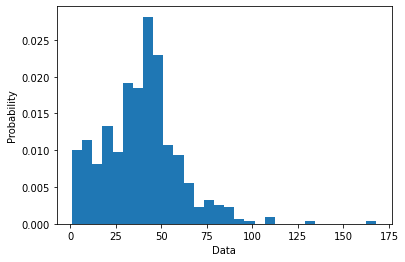

In [87]:
import matplotlib.pyplot as plt
import itertools

num_segments_per_book = [len(list(g[1])) for g in itertools.groupby(chunked_encoded_dataset['train']['book_title'])]

plt.hist(num_segments_per_book, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [88]:
# [(g[0], len(list(g[1]))) for g in itertools.groupby(chunked_encoded_dataset['train']['book_title'])]
start_of_segmented_book = {}
last_idx = 0
for g in itertools.groupby(chunked_encoded_dataset['train']['book_title']):
  start_of_segmented_book[g[0]] = last_idx
  last_idx = len(list(g[1])) + last_idx

In [89]:
# When batched = True, we take in multiple examples
def filter_segments(example, idx):
  if (idx - start_of_segmented_book[example['book_title']] < 30):
    return True
  else:
    return False

test = chunked_encoded_dataset['train'].filter(filter_segments, with_indices = True)

  0%|          | 0/22 [00:00<?, ?ba/s]

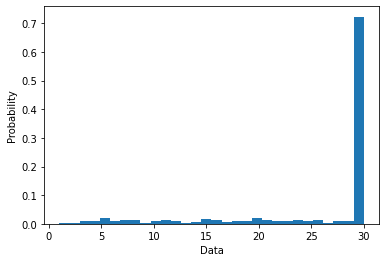

In [90]:
num_segments_per_book = [len(list(g[1])) for g in itertools.groupby(test['book_title'])]

plt.hist(num_segments_per_book, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [91]:
chunked_encoded_dataset['train'] = chunked_encoded_dataset['train'].filter(filter_segments, with_indices = True)

  0%|          | 0/22 [00:00<?, ?ba/s]

# GoodReads Success Prediction

## Transformer --> Classification

In [ ]:
db_config

DistilBertConfig {
  "_name_or_path": "./artifacts/model-1cc2m6k4:v0",
  "activation": "gelu",
  "alpha": 0.5928,
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.2436,
  "dim": 768,
  "dropout": 0.3877,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.11.0.dev0",
  "vocab_size": 30523
}

In [85]:
from MultiTaskExtensions import DistilBERTForMultipleSequenceClassification
from transformers import DistilBertConfig
pretrained_model_name_or_path = config['Model']['name']

if (eval(config['WandB']['use_WandB_pretrained'])):
  run = wandb.init()
  # artifact = run.use_artifact('lucaguarro/goodreads_success_predictor/model-1fajaalf:v0', type='model')
  artifact = run.use_artifact('lucaguarro/goodreads_success_predictor/model-3d16pz7v:v0', type='model')
  pretrained_model_name_or_path = artifact.download()

if (eval(config['Model']['multi_task'])):
  metric_for_best_model = 'eval_s_f1'
  if (config['Model']['name'] == 'distilbert-base-uncased'):
    from MultiTaskExtensions import DistilBERTForMultipleSequenceClassification
    db_config = DistilBertConfig.from_pretrained(pretrained_model_name_or_path)
    db_config.update({'_name_or_path': pretrained_model_name_or_path, 'alpha': 0.5928, 'attention_dropout': 0.2436, 'dropout': 0.3}) # dropout': 0.3877
    print(db_config)
    model = DistilBERTForMultipleSequenceClassification.from_pretrained(pretrained_model_name_or_path = db_config._name_or_path, config = db_config)
  else:
    from MultiTaskExtensions import BertForMultipleSequenceClassification
    model = BertForMultipleSequenceClassification.from_pretrained(pretrained_model_name_or_path)

else:
  print("standard model", pretrained_model_name_or_path)
  metric_for_best_model = 'eval_f1'
  model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path)
  model.resize_token_embeddings(len(tokenizer))

wandb: Downloading large artifact model-3d16pz7v:v0, 255.57MB. 3 files... Done. 0:0:0


DistilBertConfig {
  "_name_or_path": "./artifacts/model-3d16pz7v:v0",
  "activation": "gelu",
  "alpha": 0.5928,
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.2436,
  "dim": 768,
  "dropout": 0.3,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.11.0.dev0",
  "vocab_size": 30523
}

2 8


Some weights of the model checkpoint at ./artifacts/model-3d16pz7v:v0 were not used when initializing DistilBERTForMultipleSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBERTForMultipleSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBERTForMultipleSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBERTForMultipleSequenceClassification were not initialized from the model checkpoint at ./artifacts/model-3d16pz7v:v0 and are newly initialized: ['classifier

In [ ]:
%env WANDB_PROJECT=goodreads_success_predictor_80_20

training_args = TrainingArguments(
    'goodreads_success_predictor_80_20_DistilBERT_30segs_3vv_HPs_mlmguarro',
    # output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    learning_rate=0.00003969,
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=0,                # number of warmup steps for learning rate scheduler
    warmup_ratio=0,
    weight_decay=0.1,               # strength of weight decay
    # logging_dir='./logs',            # directory for storing logs
    logging_steps=5,
    # gradient_accumulation_steps=2,
    evaluation_strategy = "steps",
    eval_steps = 50, # prob better if set to 601 that way it evenly divides into the epochs
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_s_f1',
    greater_is_better = True,
    report_to = "wandb",
    save_total_limit = 5
    # learning rate, play around with weight_decay
    # select best model (and not the last one); use validation loss to pick the best model
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=chunked_encoded_dataset['train'],         # training dataset             # evaluation dataset
    eval_dataset=chunked_encoded_dataset['validation'], 
    compute_metrics = compute_metrics
)

trainer.train()

PyTorch: setting up devices
The following columns in the training set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: token_type_ids, book_title.
***** Running training *****
  Num examples = 14244
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 8910
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


env: WANDB_PROJECT=goodreads_success_predictor_80_20


Step,Training Loss,Validation Loss,S Accuracy,S F1,S Precision,S Recall,G Accuracy,G F1,G Precision,G Recall
50,0.616600,0.817214,0.742170,0.713225,0.728274,0.742170,0.742170,0.167458,0.122333,0.271581
100,0.595700,0.803619,0.728801,0.699273,0.709619,0.728801,0.728801,0.171994,0.131326,0.269290
150,0.574100,0.814331,0.735867,0.702416,0.720814,0.735867,0.735867,0.159855,0.116434,0.261841
200,0.475500,0.858730,0.731474,0.698140,0.714170,0.731474,0.731474,0.151865,0.110124,0.257257
250,0.474800,0.927366,0.705118,0.675077,0.677848,0.705118,0.705118,0.133305,0.096176,0.237013
300,0.394500,0.904332,0.685829,0.689497,0.694310,0.685829,0.685829,0.144406,0.103438,0.248281
350,0.556500,0.979226,0.692513,0.681921,0.676937,0.692513,0.692513,0.143050,0.101391,0.249618
400,0.482200,0.948480,0.693659,0.663554,0.663112,0.693659,0.693659,0.159259,0.125508,0.247899
450,0.405500,0.960891,0.690604,0.674614,0.669512,0.690604,0.690604,0.164843,0.130708,0.250382
500,0.567900,0.986745,0.712949,0.676199,0.687206,0.712949,0.712949,0.160050,0.117309,0.256875


The following columns in the evaluation set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: token_type_ids, book_title.
***** Running Evaluation *****
  Num examples = 5236
  Batch size = 32
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to goodreads_success_predictor_80_20_DistilBERT_30segs_3vv_HPs_mlmguarro/checkpoint-50
Configuration saved in goodreads_success_predictor_80_20_DistilBERT_30segs_3vv_HPs_mlmguarro/checkpoint-50/config.json
Model weights saved in goodreads_success_predictor_80_20_DistilBERT_30segs_3vv_HPs_mlmguarro/checkpoint-50/pytorch_model.bin
Deleting older checkpoint [goodreads_success_predictor_80_20_DistilBERT_30

TrainOutput(global_step=8910, training_loss=0.16553175314572585, metrics={'train_runtime': 28066.3183, 'train_samples_per_second': 5.075, 'train_steps_per_second': 0.317, 'total_flos': 1.8871348230144e+16, 'train_loss': 0.16553175314572585, 'epoch': 10.0})

In [ ]:
chunked_encoded_dataset['train']['labels'][0]

[0, 6]

## Scorer

In [ ]:
from MultiTaskExtensions import DistilBERTForMultipleSequenceClassification

In [ ]:
run = wandb.init()
# artifact = run.use_artifact('lucaguarro/DistilbertMultitaskHPSearch/model-3igwy2id:v0', type='model')
artifact = run.use_artifact('lucaguarro/DistilbertMultitaskHPSearch/model-3vvi0uoq:v0', type='model')
artifact_dir = artifact.download()

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)


wandb: Downloading large artifact model-3vvi0uoq:v0, 255.48MB. 3 files... Done. 0:0:0


In [ ]:
model = DistilBERTForMultipleSequenceClassification.from_pretrained(artifact_dir)
trainer = Trainer(
    model=model
)

2 8


In [ ]:
from scores import ModelScorer

In [ ]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset, for_multitask=True)

The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: book_title, token_type_ids.
***** Running Prediction *****
  Num examples = 18939
  Batch size = 8


Getting predictions on validation set


The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: book_title, token_type_ids.
***** Running Prediction *****
  Num examples = 39089
  Batch size = 8


Getting predictions on test set


*******************************************************************
********************** SEGMENTED F1 SCORE *************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The max weighted f1 score is 0.7566801724103519 with a threshold of 0.6200000000000002 



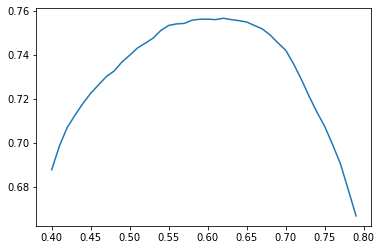

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6935629662254417 using the validated threshold of 0.6200000000000002 



In [ ]:
m_scorer.get_segmented_f1_scores()

*******************************************************************
************************ BOOK F1 SCORE ****************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The max weighted f1 score is 0.7975696365984135 with a threshold of 0.6900000000000003 



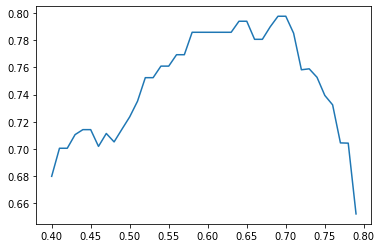

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6592042880707617 using a threshold of 0.5 

The weighted f1 score is 0.7175911838649336 using the validated threshold of 0.6900000000000003 



In [ ]:
m_scorer.get_book_f1_scores()

# Hyperparameter Tuning

multitask hyperparameter tuning

In [ ]:
# saves our models to artifacts in WandB
%env WANDB_LOG_MODEL=true
wandb.login()
%env WANDB_PROJECT=DistilbertMultitaskHPSearch

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)


env: WANDB_LOG_MODEL=true
env: WANDB_PROJECT=DistilbertMultitaskHPSearch


In [ ]:
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'book_title', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 21539
    })
    validation: Dataset({
        features: ['attention_mask', 'book_title', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 5236
    })
    test: Dataset({
        features: ['attention_mask', 'book_title', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 10816
    })
})

In [93]:
def compute_metrics_single(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def compute_metrics_multi(pred):
    preds = pred.predictions
    label_ids = pred.label_ids

    success_labels = label_ids[:, 0]
    genre_labels = label_ids[:, 1]

    success_preds = preds[:, 0:2].argmax(1)
    genre_preds = preds[:, 2:6].argmax(1)

    s_precision, s_recall, s_f1, _ = precision_recall_fscore_support(success_labels, success_preds, average='weighted')
    s_acc = accuracy_score(success_labels, success_preds)

    g_precision, g_recall, g_f1, _ = precision_recall_fscore_support(genre_labels, genre_preds, average='weighted')
    g_acc = accuracy_score(success_labels, success_preds)

    return {
        's_accuracy': s_acc,
        's_f1': s_f1,
        's_precision': s_precision,
        's_recall': s_recall,
        'g_accuracy': g_acc,
        'g_f1': g_f1,
        'g_precision': g_precision,
        'g_recall': g_recall
    }

if eval(config['Model']['multi_task']):
  print('multi')
  # from scores import compute_metrics_multi
  compute_metrics = compute_metrics_multi
else:
  print('single')
  # from scores import compute_metrics_single
  compute_metrics = compute_metrics_single

def my_objective(metrics):
    # Your elaborate computation here
    if eval(config['Model']['multi_task']):
      return metrics['eval_s_f1']
    else:
      return metrics['eval_f1']

multi


In [ ]:
db_config_base = DistilBertConfig.from_pretrained('/content/drive/MyDrive/Thesis/BookSuccessPredictor/saved_models/DistilBertPretrained')
db_config_base.update({'_name_or_path': '/content/drive/MyDrive/Thesis/BookSuccessPredictor/saved_models/DistilBertPretrained', 'alpha': 0.2, 'dropout': 0.8})

In [ ]:
db_config_base

DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/Thesis/BookSuccessPredictor/saved_models/DistilBertPretrained",
  "activation": "gelu",
  "alpha": 0.2,
  "architectures": [
    "DistilBertModel"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.8,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.10.0.dev0",
  "vocab_size": 30523
}

In [ ]:
test = DistilBERTForMultipleSequenceClassification.from_pretrained(pretrained_model_name_or_path = db_config_base._name_or_path, config = db_config_base)

In [ ]:
# tune_config_pop_based = {
#     "per_device_train_batch_size": 16,
#     "per_device_eval_batch_size": 32,
#     "num_train_epochs": 1,
#     "max_steps": 1 if smoke_test else -1,  # Used for smoke test.
#     "wandb": {
#         "project": "DistilbertMultitaskHPSearch",
#         "group": "Search1",
#         "api_key": "XXXXXXXX",
#         "log_config": True
#     }
# }

# scheduler = PopulationBasedTraining(
#     time_attr="training_iteration",
#     metric="eval_s_f1",
#     mode="max",
#     perturbation_interval=60,
#     hyperparam_mutations={
#         "weight_decay": tune.uniform(0.0, 0.3),
#         "learning_rate": tune.uniform(1e-5, 5e-5),
#         "per_device_train_batch_size": [16],
#     })

In [ ]:
from transformers.modeling_outputs import SequenceClassifierOutput
from torch import nn
import torch
from torch.nn import CrossEntropyLoss, MSELoss

from transformers import DistilBertPreTrainedModel, DistilBertModel
class DistilBERTForMultipleSequenceClassification(DistilBertPreTrainedModel):
    def __init__(self, config, num_labels1 = 2, num_labels2 = 8):
        super().__init__(config)
        self.num_labels1 = num_labels1
        self.num_labels2 = num_labels2
        print(self.num_labels1, self.num_labels2)
        self.alpha = config.alpha
        self.config = config

        self.distilbert = DistilBertModel(config)
        self.pre_classifier = nn.Linear(config.dim, config.dim)
        self.classifier1 = nn.Linear(config.dim, self.num_labels1)
        self.classifier2 = nn.Linear(config.dim, self.num_labels2)
        self.dropout = nn.Dropout(config.dropout)

        self.init_weights()


    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the sequence classification/regression loss. Indices should be in :obj:`[0, ...,
            config.num_labels - 1]`. If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        distilbert_output = self.distilbert(
              input_ids=input_ids,
              attention_mask=attention_mask,
              head_mask=head_mask,
              inputs_embeds=inputs_embeds,
              output_attentions=output_attentions,
              output_hidden_states=output_hidden_states,
              return_dict=return_dict,
          )
        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
        pooled_output = nn.ReLU()(pooled_output)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        logits1 = self.classifier1(pooled_output)
        logits2 = self.classifier2(pooled_output)
        logits = torch.cat([logits1, logits2], 1)

        loss = None
        if labels is not None:
            #if self.config.problem_type is None:
            #self.config.problem_type = "single_label_classification"
            
            if self.num_labels1 > 1:
                loss_fct1 = CrossEntropyLoss()
                loss1 = loss_fct1(logits1.view(-1, self.num_labels1), labels[:, 0].view(-1))
            else:
                loss_fct1 = MSELoss()
                loss1 = loss_fct1(logits1.view(-1), labels[:, 0].view(-1))

            if self.num_labels2 > 1:
                loss_fct2 = CrossEntropyLoss()
                loss2 = loss_fct2(logits2.view(-1, self.num_labels2), labels[:, 1].view(-1))
            else:
                loss_fct2 = MSELoss()
                loss2 = loss_fct2(logits2.view(-1), labels[:, 1].view(-1))
            loss = self.alpha*loss1 + (1-self.alpha)*loss2 

        if not return_dict:
            output = (logits,) + outputs[2:] #not sure if this works
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=distilbert_output.hidden_states, #hidden_states,
            attentions=distilbert_output.attentions, #attentions,
        )

In [ ]:
def tune_transformer(num_samples=8, gpus_per_trial=0, smoke_test=False):
    data_dir_name = "./data" if not smoke_test else "./test_data"
    data_dir = os.path.abspath(os.path.join(os.getcwd(), data_dir_name))
    if not os.path.exists(data_dir):
        os.mkdir(data_dir, 0o755)

    def get_model(params):
        db_config = db_config_base
        print("printing params", params)
        if params is not None:
          db_config.update({'_name_or_path': '/content/drive/MyDrive/Thesis/BookSuccessPredictor/saved_models/DistilBertPretrained', 'alpha': params['alpha'], 'attention_dropout': params['attention_dropout'], 'dropout': params['dropout']})
        return DistilBERTForMultipleSequenceClassification.from_pretrained(pretrained_model_name_or_path = db_config_base._name_or_path, config = db_config_base)

    train_dataset = chunked_encoded_dataset['train']
    eval_dataset = chunked_encoded_dataset['validation']

    training_args = TrainingArguments(
        output_dir="DistilBertMultitask_HPsearch",
        learning_rate=1e-5,  # config
        do_train=True,
        do_eval=True,
        no_cuda=gpus_per_trial <= 0,
        evaluation_strategy="steps",
        save_total_limit = 5,
        logging_strategy="steps",
        logging_steps=5,
        eval_steps=5,
        load_best_model_at_end=True,
        # metric_for_best_model='eval_s_f1',
        # greater_is_better=True,
        num_train_epochs=0.9,  # config
        per_device_train_batch_size=16,  # config
        per_device_eval_batch_size=16,  # config
        warmup_steps=0,
        weight_decay=0.1,  # config
        logging_dir="./logs",
        skip_memory_metrics=True)

    tune_config_ASHA = {
        "attention_dropout": tune.uniform(0.15,0.4),
        "dropout": tune.uniform(0.15, 0.4),
        "alpha": tune.uniform(0.3,0.7),
        "learning_rate": tune.loguniform(1e-5, 1e-4),
        "per_device_train_batch_size": tune.choice([16]),
        "num_train_epochs": tune.choice([0.9]),
        "wandb": {
            "project": "DistilbertMultitaskHPSearch",
            "group": "Search1",
            "api_key": config['WandB']['api_key'],
            "log_config": True
        }
    }

    trainer = Trainer(
        model_init=get_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics)
    

    # scheduler = ASHAScheduler(
    #     metric="eval_s_f1",
    #     mode="max",
    #     max_t=1000,
    #     grace_period=30,
    #     reduction_factor=1.5)

    # scheduler = ASHAScheduler(
    #     metric="eval_s_f1",
    #     mode="max",
    #     max_t=1,
    #     grace_period=1,
    #     reduction_factor=2)

    reporter = CLIReporter(
        parameter_columns={
            "weight_decay": "w_decay",
            "learning_rate": "lr",
            "dropout": "dropout",
            "alpha": "alpha",
            "per_device_train_batch_size": "train_bs/gpu",
            "num_train_epochs": "num_epochs"
        },
        metric_columns=[
            "eval_s_accuracy", "eval_loss", "eval_s_f1", "steps", "training_iteration"
        ])

    trainer.hyperparameter_search(
        hp_space=lambda _: tune_config_ASHA,
        backend="ray",
        # compute_objective=my_objective,
        direction="maximize",
        n_trials=num_samples,
        resources_per_trial={
            "cpu": 2,
            "gpu": gpus_per_trial
        },
        # scheduler=scheduler,
        keep_checkpoints_num=1,
        checkpoint_score_attr="training_iteration",
        stop={"training_iteration": 1} if smoke_test else None,
        progress_reporter=reporter,
        local_dir="~/ray_results/",
        name="tune_transformer",
        loggers=DEFAULT_LOGGERS + (WandbLogger,))
        # time_budget_s=60*60*10) # 10 hours

In [ ]:
tune_transformer(num_samples=3, gpus_per_trial=1, smoke_test=False)
# tune_transformer(num_samples=1, gpus_per_trial=0, smoke_test=True)

standard hyperparameter tuning

In [ ]:
# saves our models to artifacts in WandB
import wandb
%env WANDB_LOG_MODEL=true
wandb.login()

In [ ]:
import os
import pickle

import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import PopulationBasedTraining
from transformers import AutoConfig, \
    AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from ray.tune.logger import DEFAULT_LOGGERS
from ray.tune.integration.wandb import WandbLoggerCallback, WandbLogger
from transformers import ElectraTokenizerFast, ElectraForSequenceClassification, BertTokenizer, BertForSequenceClassification

In [ ]:
model_name = 'bert-base-uncased'

In [ ]:
project_name = "BERT-base-uncased-HP-Tuning"
%env WANDB_PROJECT=BERT-base-uncased-HP-Tuning

env: WANDB_PROJECT=BERT-base-uncased-HP-Tuning


In [ ]:
from datasets import DatasetDict

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BERT_UNCASED_NER_512/train_dataset.pkl", "rb") as input_file:
  train_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BERT_UNCASED_NER_512/val_dataset.pkl", "rb") as input_file:
  val_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BERT_UNCASED_NER_512/test_dataset.pkl", "rb") as input_file:
  test_dataset = pickle.load(input_file)

chunked_encoded_dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})
chunked_encoded_dataset = chunked_encoded_dataset.rename_column('success_label', 'labels')

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def tune_transformer(num_samples=8,
                     gpus_per_trial=0,
                     smoke_test=False,
                     ray_address=None):
    ray.init(ray_address, log_to_driver=True)
    data_dir_name = "./data" if not smoke_test else "./test_data"
    data_dir = os.path.abspath(os.path.join(os.getcwd(), data_dir_name))
    if not os.path.exists(data_dir):
        os.mkdir(data_dir, 0o755)

    # Change these as needed.
    # model_name = 'google/electra-small-discriminator' if not smoke_test \
    #     else 'google/electra-small-discriminator'
    task_name = "grs"

    task_data_dir = os.path.join(data_dir, task_name.upper())

    num_labels = 2

    # config = AutoConfig.from_pretrained(
    #     model_name, num_labels=num_labels, finetuning_task=task_name)

    # Download and cache tokenizer, model, and features
    print("Downloading and caching Tokenizer")
    # tokenizer = ElectraTokenizerFast.from_pretrained('google/electra-small-discriminator', additional_special_tokens = ['[CHARACTER]'])
    tokenizer = BertTokenizer.from_pretrained(model_name, additional_special_tokens = ['[CHARACTER]'])
    
    # Triggers tokenizer download to cache
    # print("Downloading and caching pre-trained model")
    # AutoModelForSequenceClassification.from_pretrained(
    #     model_name,
    #     config=config,
    # )

    def get_model():
        # model = ElectraForSequenceClassification.from_pretrained('/content/drive/MyDrive/Thesis/Models/ELECTRA_small_pretrained', num_labels=2)
        model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
        model.resize_token_embeddings(len(tokenizer))
        return model

    train_dataset = chunked_encoded_dataset['train']
    eval_dataset = chunked_encoded_dataset['validation']

    training_args = TrainingArguments(
        project_name,
        # output_dir=".",
        learning_rate=1e-5,  # config
        do_train=True,
        do_eval=True,
        no_cuda=gpus_per_trial <= 0,
        evaluation_strategy="epoch",
        load_best_model_at_end=True,
        num_train_epochs=2,  # config
        max_steps=-1,
        per_device_train_batch_size=16,  # config
        per_device_eval_batch_size=16,  # config
        warmup_steps=0,
        weight_decay=0.1,  # config
        # logging_dir="./logs",
    )

    training_args._n_gpu = gpus_per_trial

    trainer = Trainer(
        model_init=get_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics)

    tune_config = {
        # "per_device_train_batch_size": 16,
        "per_device_eval_batch_size": 32,
        "num_train_epochs": tune.choice([2, 3, 4, 5]),
        "max_steps": 1 if smoke_test else -1,  # Used for smoke test.
        "wandb": {
            "project": project_name,
            "api_key": config['WandB']['api_key'],
            "log_config": True
        }
    }

    scheduler = PopulationBasedTraining(
        time_attr="training_iteration",
        metric="eval_f1",
        mode="max",
        perturbation_interval=1,
        hyperparam_mutations={
            "weight_decay": tune.uniform(0.0, 0.3),
            "warmup_steps": tune.choice([0, 50, 100, 500, 1000]),
            "learning_rate": tune.uniform(1e-5, 4e-5),
            "per_device_train_batch_size": [8, 16],
        })

    reporter = CLIReporter(
        parameter_columns={
            "weight_decay": "w_decay",
            "learning_rate": "lr",
            "per_device_train_batch_size": "train_bs/gpu",
            "num_train_epochs": "num_epochs"
        })

    trainer.hyperparameter_search(
        hp_space=lambda _: tune_config,
        backend="ray",
        n_trials=num_samples,
        resources_per_trial={
            "cpu": 1,
            "gpu": gpus_per_trial
        },
        scheduler=scheduler,
        keep_checkpoints_num=1,
        checkpoint_score_attr="training_iteration",
        stop={"training_iteration": 1} if smoke_test else None,
        progress_reporter=reporter,
        local_dir="~/ray_results/",
        name="tune_transformer_pbt",
        # log_to_file=True,
        loggers=DEFAULT_LOGGERS + (WandbLogger, ),
        time_budget_s=60*15
    )

In [ ]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument(
    "--smoke-test", action="store_true", help="Finish quickly for testing")
parser.add_argument(
    "--ray-address",
    type=str,
    default=None,
    help="Address to use for Ray. "
    "Use \"auto\" for cluster. "
    "Defaults to None for local.")
args, _ = parser.parse_known_args()

if args.smoke_test:
    tune_transformer(
        num_samples=1,
        gpus_per_trial=0,
        smoke_test=True,
        ray_address=args.ray_address)
else:
    # You can change the number of GPUs here:
    tune_transformer(
        num_samples=15, gpus_per_trial=1, ray_address=args.ray_address)

In [ ]:
ray.shutdown()

# UNNEEDED CODE

In [ ]:
def tokenize_w_overlap(example, tokenizer, chunk_len = 512, overlap_len = 50):
    data_tokenize = tokenizer(example['text'], 
                    max_length = chunk_len,
                    add_special_tokens=True,
                    return_attention_mask=True,
                    return_token_type_ids=True,
                    return_overflowing_tokens = True,
                    return_tensors = 'np')

    long_terms_token = []
    input_ids_list = []
    attention_mask_list = []
    token_type_ids_list = []
    targets_list = []

    previous_input_ids = data_tokenize["input_ids"].reshape(-1)
    previous_attention_mask = data_tokenize["attention_mask"].reshape(-1)
    previous_token_type_ids = data_tokenize["token_type_ids"].reshape(-1)
    remain = data_tokenize["overflowing_tokens"].reshape(-1)
    
    input_ids_list.append(previous_input_ids)
    attention_mask_list.append(previous_attention_mask)
    token_type_ids_list.append(previous_token_type_ids)

    if remain is not None:
      idxs = range(len(remain)+chunk_len)
      idxs = idxs[(chunk_len-overlap_len-2)
                    ::(chunk_len-overlap_len-2)]
      input_ids_first_overlap = previous_input_ids[-(
          overlap_len+1):-1]
      start_token = np.array([101])
      end_token = np.array([102])

      for i, idx in enumerate(idxs):
          if i == 0:
              input_ids = np.concatenate((input_ids_first_overlap, remain[:idx])) # building the 2nd chunk
          elif i == len(idxs):
              input_ids = remain[idx:]
          elif previous_idx >= len(remain):
              break
          else:
              input_ids = remain[(previous_idx-overlap_len):idx]

          previous_idx = idx

          nb_token = len(input_ids)+2
          attention_mask = np.ones(chunk_len)
          attention_mask[nb_token:chunk_len] = 0 # only will take effect on the last chunk
          token_type_ids = np.zeros(chunk_len)
          input_ids = np.concatenate((start_token, input_ids, end_token))

          if chunk_len-nb_token > 0: # add padding, only can pass on last chunk
              padding = np.zeros(chunk_len-nb_token)
              input_ids = np.concatenate((input_ids, padding))

          input_ids_list.append(input_ids)
          attention_mask_list.append(attention_mask)
          token_type_ids_list.append(token_type_ids)

      print(input_ids_list)

      return {
          'input_ids': input_ids_list,  # torch.tensor(ids, dtype=torch.long),
          'attention_mask': attention_mask_list,
          'token_type_ids': token_type_ids_list,
          'success_label': np.array([example['success_label']] * len(input_ids_list)),
          'genre': np.array([example['genre']] * len(input_ids_list))
          # 'len': [np.array(len(targets_list), dtype=torch.long)]
      }

In [ ]:
# When batched = True, we take in multiple examples
def chunk_and_encode_examples_w_overlap(examples):
  mega_dict = {'attention_mask': [], 'genre': [], 'input_ids': [], 'success_label': [], 'token_type_ids': [], 'book_title': []}
  for i in range(len(examples['text'])):
    book_sample = {'text': examples['text'][i], 'genre': examples['genre'][i], 'success_label': examples['success_label'][i], 'book_title':examples['book_title'][i]}
    dictOfTokenizedChunks = tokenize_w_overlap(book_sample, tokenizer)
    for key, value in dictOfTokenizedChunks.items():
      mega_dict[key].extend(value)
  return mega_dict

In [ ]:
!transformers-cli env

2021-06-21 16:18:05.542348: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
2021-06-21 16:18:07.217176: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-06-21 16:18:07.218520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-21 16:18:07.219176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-06-21 16:18:07.219234: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic libr

# Tests

### nlpbosie wtf

In [35]:
from MultiTaskExtensions import DistilBERTForMultipleSequenceClassification
from transformers import DistilBertConfig
# pretrained_model_name_or_path = config['Model']['name']
pretrained_model_name_or_path = '/content/drive/MyDrive/Thesis/BookSuccessPredictor/saved_models/DistilBertPretrained'
db_config = DistilBertConfig.from_pretrained(pretrained_model_name_or_path)
db_config.update({'_name_or_path': pretrained_model_name_or_path, 'alpha': 0.5928, 'attention_dropout': 0.2436, 'dropout': 0.3}) # 'dropout': 0.3877
localmodel = DistilBERTForMultipleSequenceClassification.from_pretrained(pretrained_model_name_or_path = db_config._name_or_path, config = db_config)

2 8


Some weights of DistilBERTForMultipleSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/Thesis/BookSuccessPredictor/saved_models/DistilBertPretrained and are newly initialized: ['classifier1.weight', 'pre_classifier.weight', 'classifier2.bias', 'classifier2.weight', 'classifier1.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
for name, param in localmodel.named_parameters():
  if name == "classifier1.weight" or name == "classifier1.bias" or name == "pre_classifier.bias":
    print(name)
    print(param)

pre_classifier.bias
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.

In [ ]:
run = wandb.init()
# artifact = run.use_artifact('lucaguarro/DistilbertMultitaskHPSearch/model-3igwy2id:v0', type='model')
artifact = run.use_artifact('lucaguarro/DistilbertMultitaskHPSearch/model-3vvi0uoq:v0', type='model')
artifact_dir = artifact.download()
randomfinetunedmodel = DistilBERTForMultipleSequenceClassification.from_pretrained(artifact_dir)

In [ ]:
for name, param in randomfinetunedmodel.named_parameters():
  if name == "classifier1.weight" or name == "classifier1.bias" or name == "pre_classifier.bias":
    print(name)
    print(param)

In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor/model-nlpbosie:v0', type='model')
artifact_dir = artifact.download()

db_config = DistilBertConfig.from_pretrained(artifact_dir)
db_config.update({'_name_or_path': artifact_dir, 'alpha': 0.5928, 'attention_dropout': 0.2436, 'dropout': 0.3}) # 'dropout': 0.3877

remotemodel = DistilBERTForMultipleSequenceClassification.from_pretrained(pretrained_model_name_or_path = db_config._name_or_path, config = db_config)

In [53]:
for name, param in remotemodel.named_parameters():
  if name == "classifier1.weight" or name == "classifier1.bias" or name == "pre_classifier.bias":
    print(name)
    print(param)

pre_classifier.bias
Parameter containing:
tensor([ 1.0426e-03,  7.0948e-04, -1.5546e-04, -5.8144e-04,  8.5666e-04,
         6.9208e-04,  1.1445e-03,  1.5423e-03,  1.0668e-03,  1.2401e-03,
        -1.4227e-03,  9.1089e-04,  8.9668e-04,  2.9021e-04,  3.4727e-03,
         7.9550e-04,  4.9250e-04,  1.4957e-03,  1.6196e-03,  1.1601e-03,
        -7.3486e-05,  2.2708e-04,  1.4244e-03,  1.0185e-03,  1.2613e-03,
         8.9047e-04,  1.0211e-03,  5.0265e-04,  3.8807e-04, -1.0391e-04,
         1.7241e-04, -5.9433e-04,  2.0685e-03,  6.2398e-04,  1.7270e-03,
        -1.0512e-03,  1.9897e-03,  4.4854e-04,  1.2809e-03,  9.0866e-04,
         1.6756e-03, -9.6448e-05,  1.0318e-04,  4.3877e-04,  1.1659e-03,
         1.9423e-03,  3.6483e-04,  1.0627e-03,  1.2165e-03,  6.7585e-04,
         1.0207e-04, -1.1111e-03,  2.6570e-03,  6.1437e-04, -1.7970e-03,
         4.6592e-04,  7.7910e-04,  1.7622e-03,  6.9072e-04,  1.7431e-03,
         1.6268e-03,  1.0731e-03,  9.0295e-04,  1.2730e-03,  1.9020e-03,
        -

In [46]:
for name, params in localmodel.named_parameters():
  if name == "distilbert.transformer.layer.5.output_layer_norm.bias":
    print(name)
    print(params)

distilbert.transformer.layer.5.output_layer_norm.bias
Parameter containing:
tensor([-4.8088e-02, -1.3539e-02,  6.8846e-02, -2.2294e-02, -4.2043e-03,
        -1.0262e-02,  3.2831e-02,  1.0168e-02,  7.8024e-04, -2.6047e-02,
        -5.0628e-02, -5.6218e-03,  1.3189e-03,  4.0637e-02, -1.7101e-02,
        -2.0957e-02,  1.2778e-02, -6.7881e-02, -1.9556e-02, -7.3538e-03,
        -3.8947e-02, -6.1032e-03, -5.4244e-03, -2.6041e-02,  7.6218e-03,
        -3.9045e-02, -2.9943e-02, -4.2277e-02, -8.0023e-02, -2.2269e-02,
         9.8851e-04, -2.0307e-02, -1.4403e-02, -7.2708e-02, -3.4602e-02,
        -3.0540e-02, -6.3581e-02, -9.3417e-02, -4.4229e-02, -5.1696e-02,
         4.3087e-02, -6.7074e-02, -2.3753e-02, -2.9312e-02, -8.2697e-02,
        -4.4135e-02, -1.0684e-01,  2.3822e-02, -8.0783e-02, -1.0022e-01,
        -8.7149e-02,  2.8777e-02,  1.4206e-02, -2.7372e-02, -6.2654e-02,
         1.7838e-02,  8.5199e-03, -1.0437e-01, -1.5176e-02, -1.0952e-01,
         2.9090e-02, -7.7967e-02,  1.2133e-02,  

In [49]:
for name, params in remotemodel.named_parameters():
  if name == "distilbert.transformer.layer.5.output_layer_norm.bias":
    print(name)
    print(params)

distilbert.transformer.layer.5.output_layer_norm.bias
Parameter containing:
tensor([-4.8088e-02, -1.3539e-02,  6.8846e-02, -2.2294e-02, -4.2043e-03,
        -1.0262e-02,  3.2831e-02,  1.0168e-02,  7.8024e-04, -2.6047e-02,
        -5.0628e-02, -5.6218e-03,  1.3189e-03,  4.0637e-02, -1.7101e-02,
        -2.0957e-02,  1.2778e-02, -6.7881e-02, -1.9556e-02, -7.3538e-03,
        -3.8947e-02, -6.1032e-03, -5.4244e-03, -2.6041e-02,  7.6218e-03,
        -3.9045e-02, -2.9943e-02, -4.2277e-02, -8.0023e-02, -2.2269e-02,
         9.8851e-04, -2.0307e-02, -1.4403e-02, -7.2708e-02, -3.4602e-02,
        -3.0540e-02, -6.3581e-02, -9.3417e-02, -4.4229e-02, -5.1696e-02,
         4.3087e-02, -6.7074e-02, -2.3753e-02, -2.9312e-02, -8.2697e-02,
        -4.4135e-02, -1.0684e-01,  2.3822e-02, -8.0783e-02, -1.0022e-01,
        -8.7149e-02,  2.8777e-02,  1.4206e-02, -2.7372e-02, -6.2654e-02,
         1.7838e-02,  8.5199e-03, -1.0437e-01, -1.5176e-02, -1.0952e-01,
         2.9090e-02, -7.7967e-02,  1.2133e-02,  

In [42]:
for name, _ in localmodel.named_parameters():
  print(name)

distilbert.embeddings.word_embeddings.weight
distilbert.embeddings.position_embeddings.weight
distilbert.embeddings.LayerNorm.weight
distilbert.embeddings.LayerNorm.bias
distilbert.transformer.layer.0.attention.q_lin.weight
distilbert.transformer.layer.0.attention.q_lin.bias
distilbert.transformer.layer.0.attention.k_lin.weight
distilbert.transformer.layer.0.attention.k_lin.bias
distilbert.transformer.layer.0.attention.v_lin.weight
distilbert.transformer.layer.0.attention.v_lin.bias
distilbert.transformer.layer.0.attention.out_lin.weight
distilbert.transformer.layer.0.attention.out_lin.bias
distilbert.transformer.layer.0.sa_layer_norm.weight
distilbert.transformer.layer.0.sa_layer_norm.bias
distilbert.transformer.layer.0.ffn.lin1.weight
distilbert.transformer.layer.0.ffn.lin1.bias
distilbert.transformer.layer.0.ffn.lin2.weight
distilbert.transformer.layer.0.ffn.lin2.bias
distilbert.transformer.layer.0.output_layer_norm.weight
distilbert.transformer.layer.0.output_layer_norm.bias
distil

### mlm versus standard distilbert

In [54]:
from MultiTaskExtensions import DistilBERTForMultipleSequenceClassification
from transformers import DistilBertConfig
pretrained_model_name_or_path = 'distilbert-base-uncased'
db_config = DistilBertConfig.from_pretrained(pretrained_model_name_or_path)
db_config.update({'_name_or_path': pretrained_model_name_or_path, 'alpha': 0.5928, 'attention_dropout': 0.2436, 'dropout': 0.3})
base_model = DistilBERTForMultipleSequenceClassification.from_pretrained(pretrained_model_name_or_path = db_config._name_or_path, config = db_config)

2 8


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBERTForMultipleSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBERTForMultipleSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBERTForMultipleSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBERTForMultipleSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier1.weight', '

In [68]:
for name, params in base_model.named_parameters():
  if name == "distilbert.transformer.layer.5.output_layer_norm.weight":
    print(name)
    print(params[60:80])

distilbert.transformer.layer.5.output_layer_norm.weight
tensor([0.6333, 0.5656, 0.5821, 0.5939, 0.6082, 0.6097, 0.6012, 0.6419, 0.6207,
        0.6154, 0.6135, 0.5925, 0.6205, 0.5988, 0.5986, 0.6311, 0.5758, 0.5687,
        0.6119, 0.5967], grad_fn=<SliceBackward>)


In [ ]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/goodreads_success_predictor/model-3d16pz7v:v0', type='model')
artifact_dir = artifact.download()

db_config = DistilBertConfig.from_pretrained(artifact_dir)
db_config.update({'_name_or_path': artifact_dir, 'alpha': 0.5928, 'attention_dropout': 0.2436, 'dropout': 0.3}) # 'dropout': 0.3877

mlmguarro = DistilBERTForMultipleSequenceClassification.from_pretrained(pretrained_model_name_or_path = db_config._name_or_path, config = db_config)

In [67]:
for name, params in mlmguarro.named_parameters():
  if name == "distilbert.transformer.layer.5.output_layer_norm.weight":
    print(name)
    print(params[60:80])

distilbert.transformer.layer.5.output_layer_norm.weight
tensor([0.6334, 0.5665, 0.5854, 0.5915, 0.6078, 0.6111, 0.5967, 0.6423, 0.6225,
        0.6134, 0.6133, 0.5902, 0.6228, 0.5950, 0.5993, 0.6312, 0.5736, 0.5670,
        0.6119, 0.5969], grad_fn=<SliceBackward>)
